In [1]:
category = ['low', 'mid', 'high'][0]
SM_RDst = 0.33
version = 'v1'
reTrain = False
plotLoss = True

# Import

In [2]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories
cat = categories[category]
import json, yaml

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from pT_calibration_reader import pTCalReader
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "       Simulation Preliminary"

Welcome to JupyROOT 6.20/07


In [4]:
#They all have to be produced with the same pileup
MCsample = {
'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
'DstmD0' : DSetLoader('B0_DstmD0_PUc0'),
'DstmDp' : DSetLoader('B0_DstmDp_PUc0'),
'DstmDsp' : DSetLoader('B0_DstmDsp_PUc0'),
'BpDstmHc' : DSetLoader('Bp_DstmHc_PUc0'),
'BmDstmHc' : DSetLoader('Bm_DstmHc_PUc0'),
'antiB0DstmHc' : DSetLoader('antiB0_DstmHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
}
processOrder = ['tau', 'mu', 'DstPip','DstPi0','DstPipPi0','DstPipPim','DstPi0Pi0','DstmDsp','DstmD0','DstmDp','BpDstmHc','BmDstmHc','antiB0DstmHc']
dSet = {}
for n, s in MCsample.iteritems():
    if not n in processOrder: raise
    dSet[n] = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name)))

../lib/analysis_utilities.py:115: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  samples = yaml.load(open(sampleFile))['samples']
../lib/analysis_utilities.py:143: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.effMCgen = yaml.load(open(effMCgenFile, 'r'))
../lib/analysis_utilities.py:147: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.effCand = yaml.load(open(effCandFile, 'r'))


In [5]:
expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4, 'single':6.} #fb^-1
lumi_tot = expectedLumi[category]
CMS_lumi.integrated_lumi = lumi_tot

# Load corrections

In [6]:
from pileup_utilities import pileupReweighter
puReweighter = pileupReweighter(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), cat)

In [7]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

In [8]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v3.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

def computeTrgSF(ds, selection=None):
    trgSF = np.ones_like(ds['q2'])
    trgSFUnc = np.zeros_like(ds['q2'])
    ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
    ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
    etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
    x = np.column_stack((ds['mu_pt'], ds['mu_eta'], ds['mu_sigdxy']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta, ip) in enumerate(x):
        ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
        iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
        iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
        trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)
        if trgSF[i] == 0:
            print pt, ip, np.abs(eta)
            raise
    return trgSF

In [9]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

def computeMuonIDSF(ds, selection=None):
    muonSF = np.ones_like(ds['q2'])
    muonSFUnc = np.zeros_like(ds['q2'])
    ptmax = hMuonIDSF.GetXaxis().GetXmax() - 0.01
    etamax = hMuonIDSF.GetYaxis().GetXmax() - 0.01
    x = np.column_stack((ds['MC_mu_pt'], ds['MC_mu_eta']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta) in enumerate(x):
        ix = hMuonIDSF.GetXaxis().FindBin(min(pt, ptmax))
        if ix == 0: ix = 1 #Remove underflows (Meaning that the MC matching failed)
        iy = hMuonIDSF.GetYaxis().FindBin(min(np.abs(eta), etamax))
        muonSF[i] = hMuonIDSF.GetBinContent(ix, iy)
        if muonSF[i] == 0:
            print pt, eta
            print ix, iy
            raise
    return muonSF

In [10]:
cal_pT = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(cat.name))

# Create dataset

In [11]:
sampleWeights = {}
sampleX = {}

RDoMC_normRatio = 2.5 # Ad hoc overall scale corr
for n in processOrder:
    print '\n----------->', n, '<-------------'
    ds = dSet[n]
    sMC = MCsample[n]
    
    nTotSelected = ds['q2'].shape[0]
    print 'N tot selected: {:.1f}k'.format(1e-3*nTotSelected)
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio
    if n == 'tau':
        nGenExp *= SM_RDst
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], decayBR[n], sMC.effCand['effCAND'], sMC.getSkimEff(cat.name+'_corr')]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.2f}k'.format(1e-3*nTotExp)
    
    weightsCentral = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
    weightsCentral *= computeTrgSF(ds)
    weightsCentral *= computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'DstmD0', 'DstmDp', 'DstmDsp','DstPi0', 'DstPipPim', 'DstPi0Pi0']: #B0 dominated final states (probably we should do something about B+ too)
        weightsCentral *= cal_pT.f['C'](ds['MC_B_pt'])
    if n in ['mu', 'tau']:
        weightsCentral *= ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
    weightsCentral *= nTotExp/nTotSelected
    print 'N tot expected (after weights): {:.3f}k'.format(1e-3*np.sum(weightsCentral))
    sampleWeights[n] = weightsCentral
    ds['pt_miss'] = ds['B_pt']*(1 - ds['mass_D0pismu']/5.27963)
    ds['pt_vis'] = ds['B_pt']*ds['mass_D0pismu']/5.27963
    sampleX[n] = np.column_stack((ds['q2'], ds['Est_mu'], ds['M2_miss'], 
                                  ds['pt_vis'], ds['mass_D0pismu'],
                                  ds['B_eta']
                                 ))
del dSet


-----------> tau <-------------
N tot selected: 61.3k
N tot expected (before weights): 1.91k
N tot expected (after weights): 2.167k

-----------> mu <-------------
N tot selected: 594.9k
N tot expected (before weights): 113.45k
N tot expected (after weights): 119.291k

-----------> DstPip <-------------
N tot selected: 36.7k
N tot expected (before weights): 3.82k
N tot expected (after weights): 4.077k

-----------> DstPi0 <-------------
N tot selected: 49.3k
N tot expected (before weights): 4.78k
N tot expected (after weights): 5.276k

-----------> DstPipPi0 <-------------
N tot selected: 3.4k
N tot expected (before weights): 0.38k
N tot expected (after weights): 0.395k

-----------> DstPipPim <-------------
N tot selected: 2.0k
N tot expected (before weights): 0.27k
N tot expected (after weights): 0.281k

-----------> DstPi0Pi0 <-------------
N tot selected: 23.3k
N tot expected (before weights): 0.49k
N tot expected (after weights): 0.549k

-----------> DstmDsp <-------------
N tot 

# Exploratory Plots

In [12]:
weightsBkg = np.array([])
xBkg = np.zeros((0,sampleX['mu'].shape[1]))
for n in sampleWeights.keys():
    if not n in ['tau', 'mu']:
        weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
        xBkg = np.concatenate((xBkg, sampleX[n]))

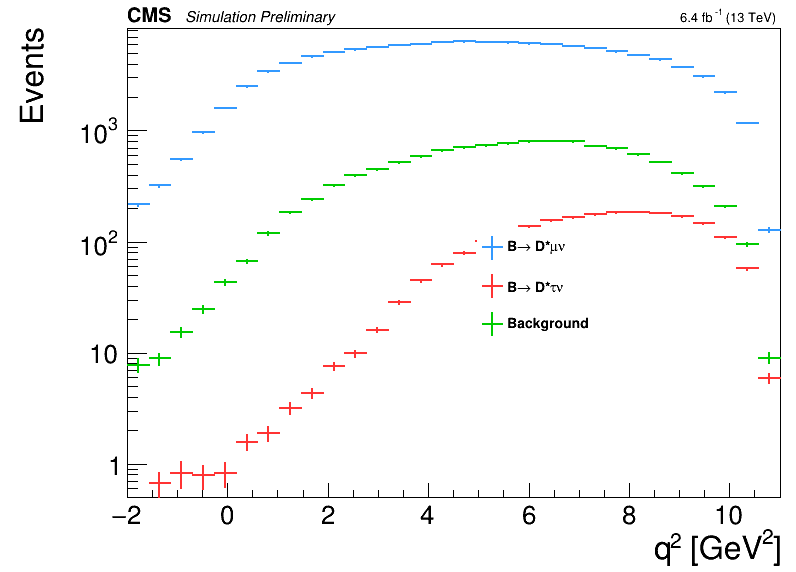

In [13]:
#q2
leg = rt.TLegend(0.6, 0.4, 0.75, 0.6)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 0], weights=sampleWeights['mu'],
                binning=[30,-2,11.], color=0, axis_title=['q^{2} [GeV^{2}]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 0], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 0], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

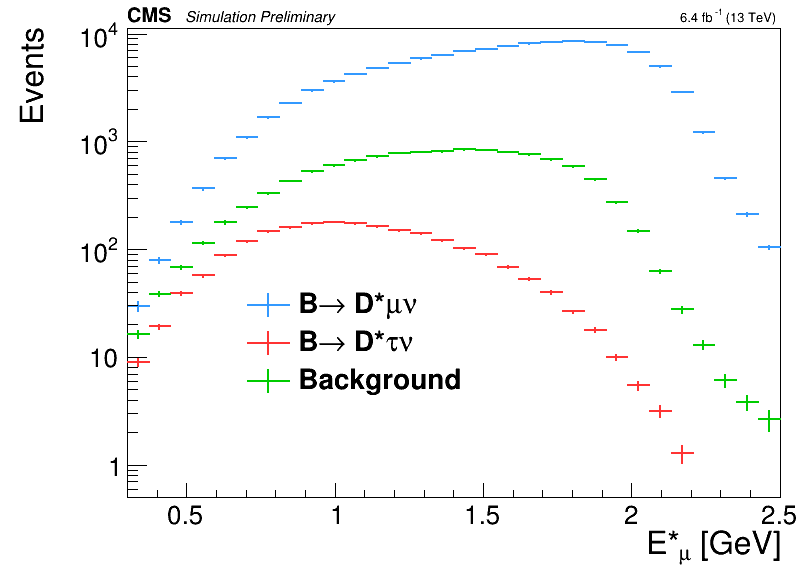

In [14]:
#Est_mu
leg = rt.TLegend(0.3, 0.3, 0.6, 0.5)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 1], weights=sampleWeights['mu'],
                binning=[30,0.3,2.5], color=0, axis_title=['E*_{#mu} [GeV]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 1], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 1], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

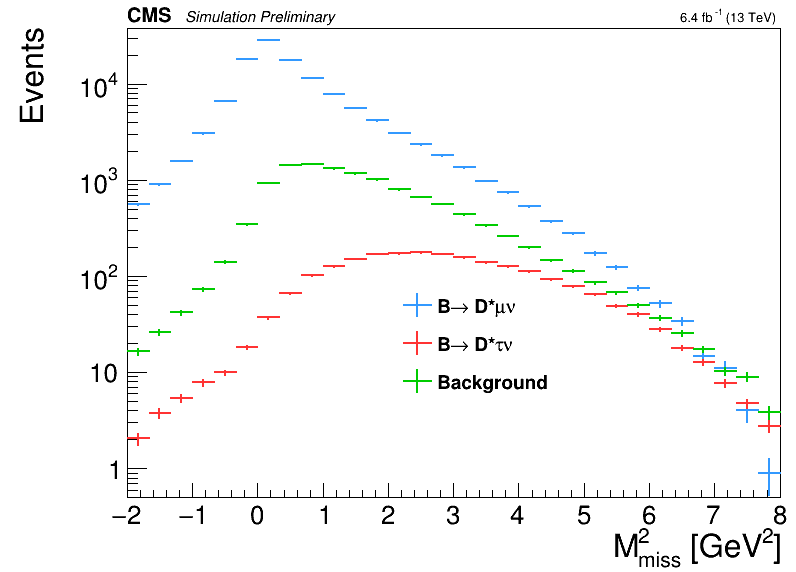

In [15]:
#M2miss
leg = rt.TLegend(0.5, 0.3, 0.7, 0.5)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 2], weights=sampleWeights['mu'],
                binning=[30,-2,8], color=0, axis_title=['M^{2}_{miss} [GeV^{2}]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 2], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 2], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

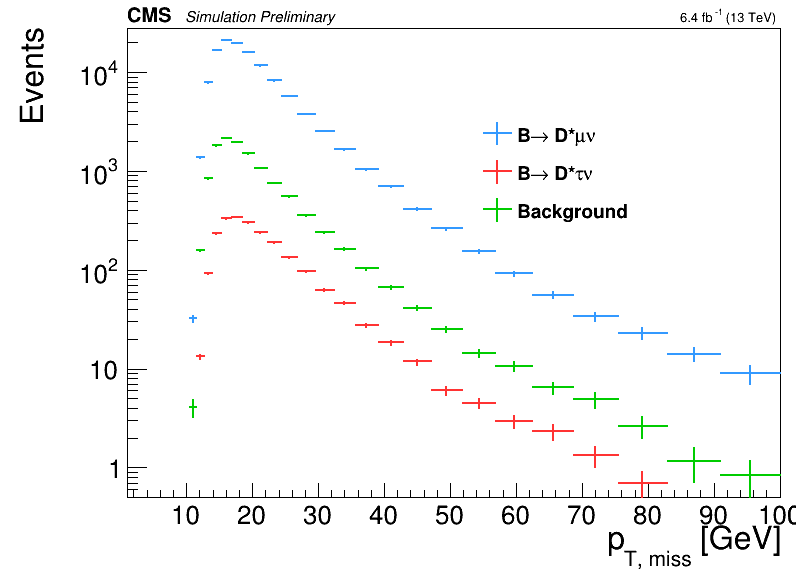

In [16]:
#ptMiss
leg = rt.TLegend(0.6, 0.6, 0.8, 0.8)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 3], weights=sampleWeights['mu'],
                binning=np.logspace(0,2,50), color=0, axis_title=['p_{T, miss} [GeV]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 3], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 3], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

In [17]:
np.set_printoptions(precision=2)
print 'Mu\n', np.corrcoef(sampleX['mu'].T)
print '\n\n'
print 'Tau\n', np.corrcoef(sampleX['tau'].T)
print '\n\n'
print 'Bkg\n', np.corrcoef(xBkg.T)

Mu
[[ 1.00e+00 -3.06e-02  3.66e-01 -1.95e-02 -5.41e-01 -4.70e-04]
 [-3.06e-02  1.00e+00 -4.99e-01 -1.10e-01  8.29e-01  2.44e-03]
 [ 3.66e-01 -4.99e-01  1.00e+00  4.51e-02 -4.36e-01 -1.20e-04]
 [-1.95e-02 -1.10e-01  4.51e-02  1.00e+00 -8.63e-02  1.03e-03]
 [-5.41e-01  8.29e-01 -4.36e-01 -8.63e-02  1.00e+00  2.45e-03]
 [-4.70e-04  2.44e-03 -1.20e-04  1.03e-03  2.45e-03  1.00e+00]]



Tau
[[ 1.   -0.11  0.58  0.12 -0.44  0.  ]
 [-0.11  1.   -0.71 -0.27  0.9  -0.  ]
 [ 0.58 -0.71  1.    0.26 -0.68 -0.  ]
 [ 0.12 -0.27  0.26  1.   -0.29  0.  ]
 [-0.44  0.9  -0.68 -0.29  1.   -0.01]
 [ 0.   -0.   -0.    0.   -0.01  1.  ]]



Bkg
[[ 1.   -0.14  0.59  0.05 -0.53  0.01]
 [-0.14  1.   -0.71 -0.25  0.89 -0.  ]
 [ 0.59 -0.71  1.    0.21 -0.74  0.  ]
 [ 0.05 -0.25  0.21  1.   -0.24  0.  ]
 [-0.53  0.89 -0.74 -0.24  1.   -0.  ]
 [ 0.01 -0.    0.    0.   -0.    1.  ]]


In [18]:
legendTxt = ['B#rightarrow D*#mu#nu', 'B#rightarrow D*#tau#nu', 'Background']
l = rt.TLatex()
l.SetTextAlign(11)
l.SetTextSize(0.05)
l.SetTextFont(42)

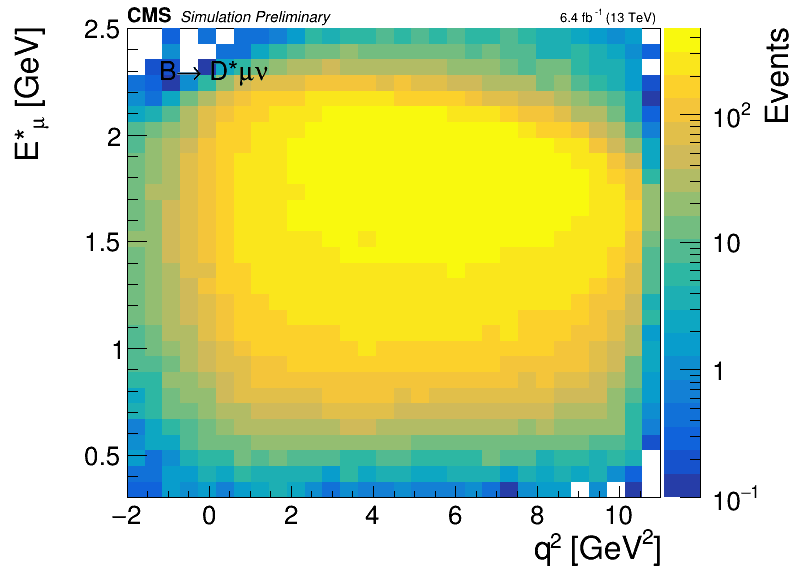

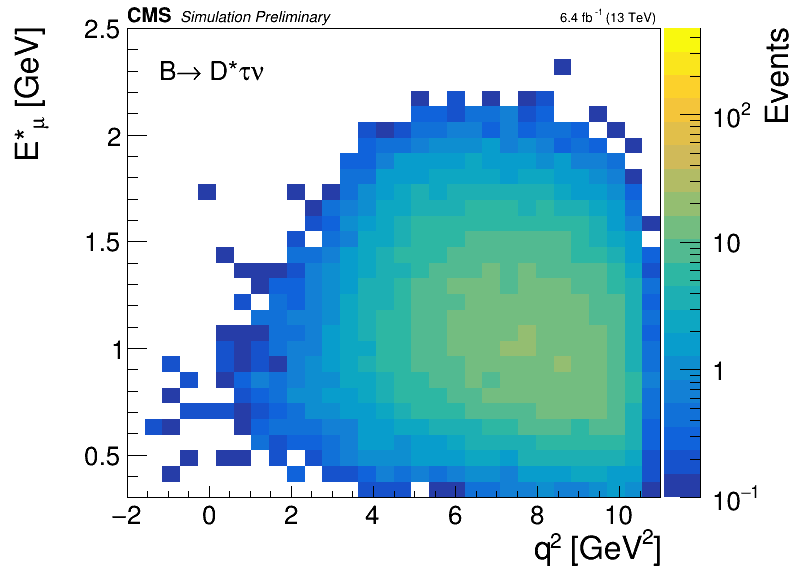

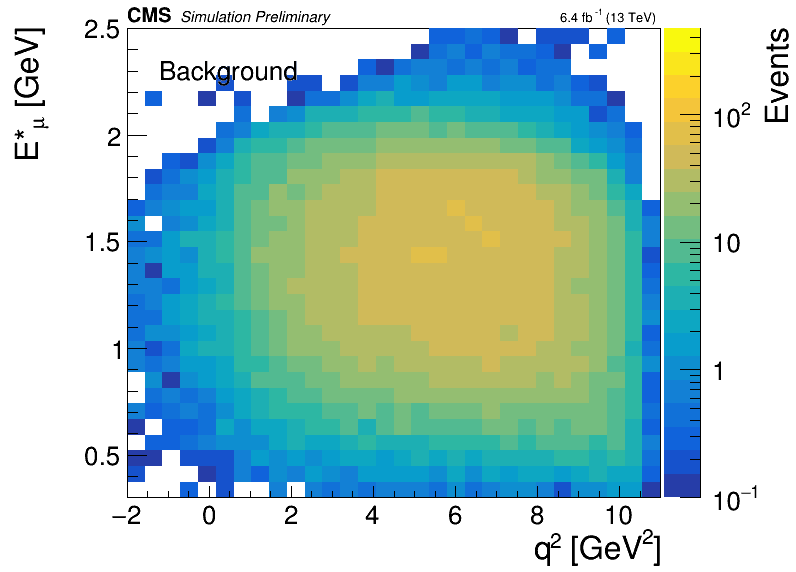

In [19]:
#q2 vs Est_mu
hl = []
h = create_TH2D(sampleX['mu'][:, 0:2], weights=sampleWeights['mu'],
                binning=[30, -2, 11, 30, 0.3, 2.5], axis_title=['q^{2} [GeV^{2}]', 'E*_{#mu} [GeV]', 'Events'])
hl.append(h)

h = create_TH2D(sampleX['tau'][:, 0:2], weights=sampleWeights['tau'], 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

h = create_TH2D(xBkg[:, 0:2], weights=weightsBkg, 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

M = np.max([h.GetMaximum() for h in hl])
for h in hl:
    h.GetZaxis().SetRangeUser(0.1, M)

for i, h in enumerate(hl):
    c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag=str(i), mR=0.17)
    c.Draw()
    c.SetLogz()
    l.DrawLatexNDC(0.2, 0.86, legendTxt[i])

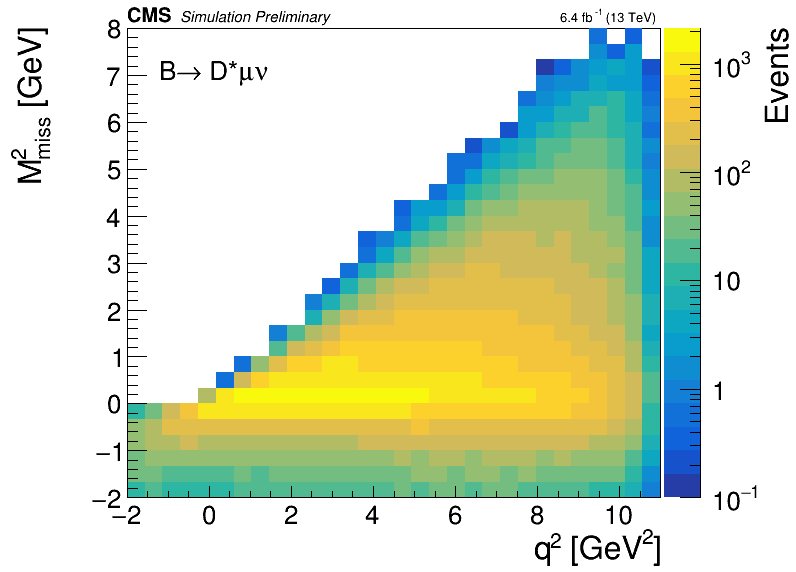

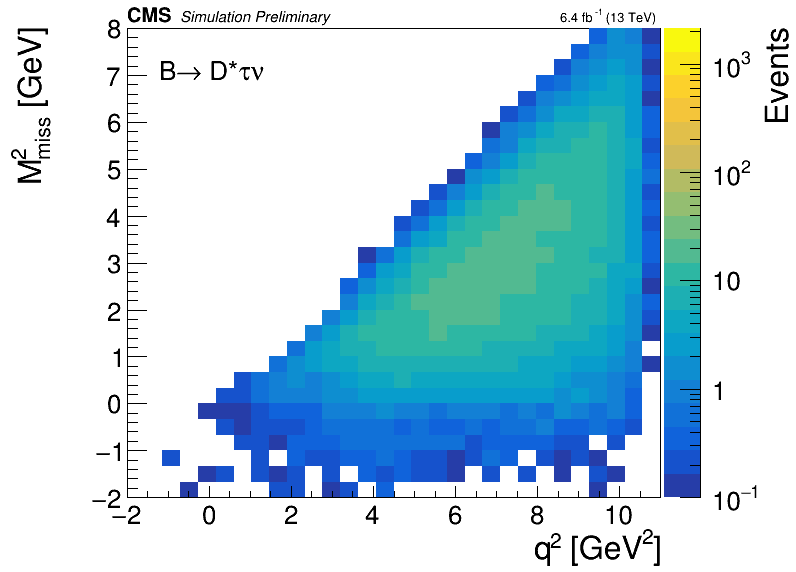

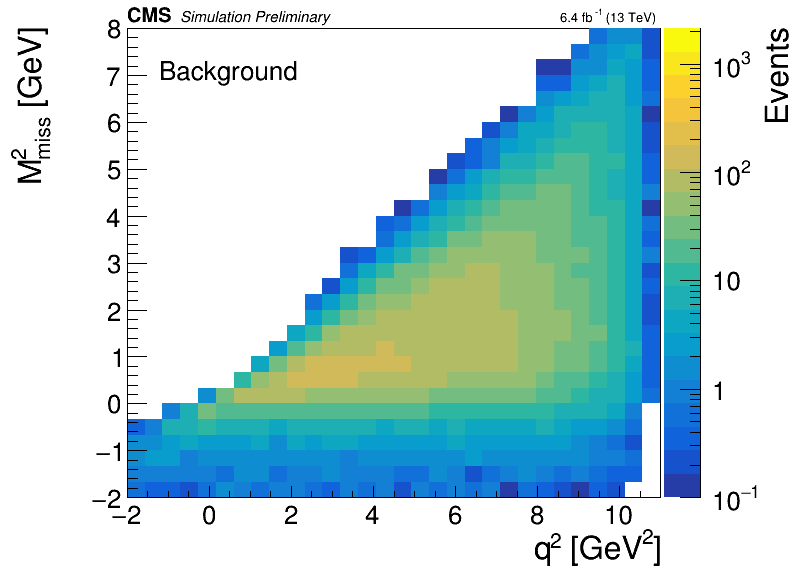

In [20]:
#q2 vs M2miss
hl = []
h = create_TH2D(sampleX['mu'][:, np.array([0,2])], weights=sampleWeights['mu'],
                binning=[30, -2, 11, 30,-2,8], axis_title=['q^{2} [GeV^{2}]', 'M^{2}_{miss} [GeV]', 'Events'])
hl.append(h)

h = create_TH2D(sampleX['tau'][:, np.array([0,2])], weights=sampleWeights['tau'], 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

h = create_TH2D(xBkg[:, np.array([0,2])], weights=weightsBkg, 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

M = np.max([h.GetMaximum() for h in hl])
for h in hl:
    h.GetZaxis().SetRangeUser(0.1, M)

for i, h in enumerate(hl):
    c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag=str(i), mR=0.17)
    c.Draw()
    c.SetLogz()
    l.DrawLatexNDC(0.2, 0.86, legendTxt[i])

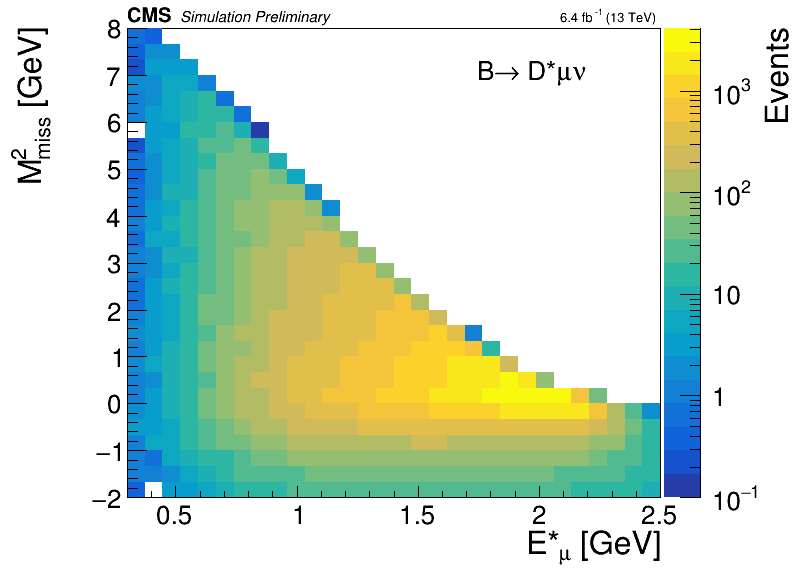

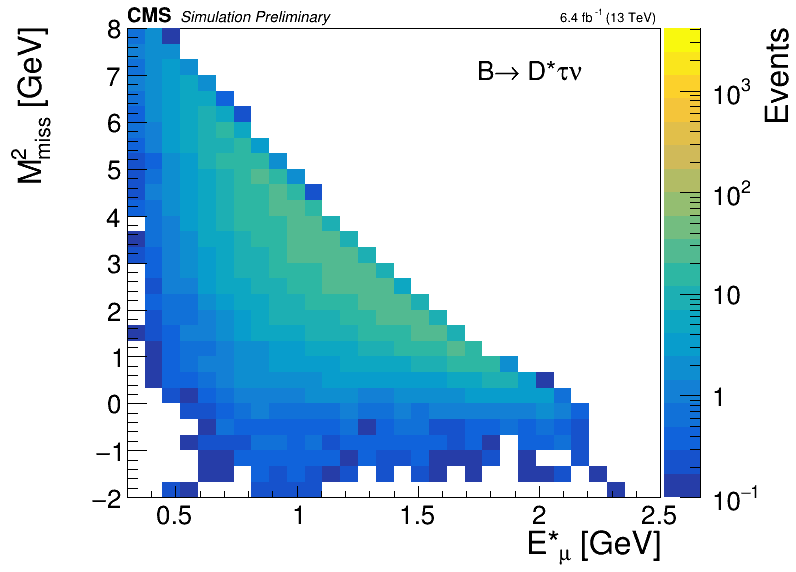

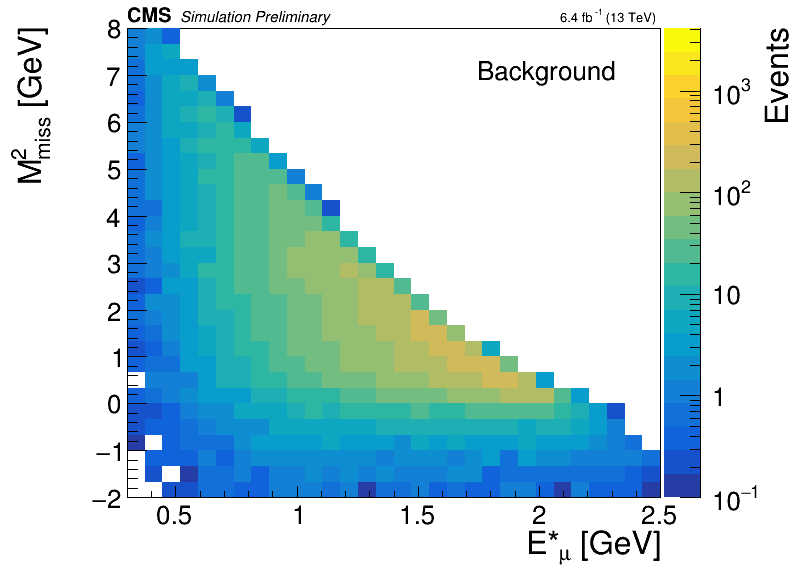

In [21]:
#Estmu vs M2miss
hl = []
h = create_TH2D(sampleX['mu'][:, np.array([1,2])], weights=sampleWeights['mu'],
                binning=[30, 0.3, 2.5, 30,-2,8], axis_title=['E*_{#mu} [GeV]', 'M^{2}_{miss} [GeV]', 'Events'])
hl.append(h)

h = create_TH2D(sampleX['tau'][:, np.array([1,2])], weights=sampleWeights['tau'], 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

h = create_TH2D(xBkg[:, np.array([1,2])], weights=weightsBkg, 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

M = np.max([h.GetMaximum() for h in hl])
for h in hl:
    h.GetZaxis().SetRangeUser(0.1, M)

for i, h in enumerate(hl):
    c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag=str(i), mR=0.17)
    c.Draw()
    c.SetLogz()
    l.DrawLatexNDC(0.6, 0.86, legendTxt[i])

# Two samples splitting (Tau vs All)

In [22]:
# weightsBkg = np.array([])
# xBkg = np.zeros((0,3))
# for n in sampleWeights.keys():
#     if not n == 'tau':
#         weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
#         xBkg = np.concatenate((xBkg, sampleX[n]))

# wTot = np.sum(weightsBkg) + np.sum(sampleWeights['tau'])
# fBkg = np.sum(weightsBkg)/wTot
# fSig = np.sum(sampleWeights['tau'])/wTot
# print fBkg
# print fSig

In [23]:
weightsBkg = np.array([])
xBkg = np.zeros((0,sampleX['mu'].shape[1]))
for n in sampleWeights.keys():
    if not n in ['tau', 'mu']:
        weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
        xBkg = np.concatenate((xBkg, sampleX[n]))

wTot = np.sum(weightsBkg) + np.sum(sampleWeights['tau']) + np.sum(sampleWeights['mu'])
fBkg = np.sum(weightsBkg)/wTot
fTau = np.sum(sampleWeights['tau'])/wTot
fMu = np.sum(sampleWeights['mu'])/wTot
print fTau, fMu, fBkg

0.01625697409967683 0.8948110924684591 0.08893193343186395


In [24]:
X = np.concatenate((xBkg, sampleX['tau'], sampleX['mu']))
weights = np.concatenate((weightsBkg/fBkg, sampleWeights['tau']/fTau, sampleWeights['mu']/fMu))

yBkg = np.zeros_like(weightsBkg)
yMu = np.zeros_like(sampleWeights['mu'])
yTau = np.ones_like(sampleWeights['tau'])
y = np.concatenate((yBkg, yTau, yMu))

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.1, random_state=0)

## BDT Classifier

In [25]:
fname = './kinObsMVA/clfGBC_tauVall_{}{}.p'.format(version, cat.name)
if reTrain or not os.path.exists(fname):
    clfGBC = GradientBoostingClassifier(
        learning_rate=0.0005, 
        n_estimators=100000, 
        min_samples_split=5, 
        min_weight_fraction_leaf=1e-4, 
        max_depth=3,
        validation_fraction=0.20,
        n_iter_no_change=100,
        tol=0.0001,
#         ccp_alpha=1e-4,
        verbose=0,
        random_state=0
    )

    clfGBC.fit(X_train, y_train, sample_weight=w_train)
    pickle.dump(clfGBC, open(fname, 'wb')) 
else:
    clfGBC = pickle.load(open(fname, 'rb'))
    
sTrain = clfGBC.score(X_train, y_train, sample_weight=w_train)
sTest = clfGBC.score(X_test, y_test, sample_weight=w_test)
print 'Accuracy: {:.5f} (train), {:.5f} (test)'.format(sTrain, sTest)
print clfGBC.feature_importances_

      Iter       Train Loss   Remaining Time 
         1           1.2730         1519.46m
         2           1.2727         1516.64m
         3           1.2725         1532.65m
         4           1.2722         1643.29m
         5           1.2719         1712.48m
         6           1.2717         1752.64m
         7           1.2714         1780.71m
         8           1.2712         1800.71m
         9           1.2709         1817.00m
        10           1.2706         1832.95m
        11           1.2704         1843.55m
        12           1.2701         1855.61m
        13           1.2698         1867.20m
        14           1.2696         1875.79m
        15           1.2693         1884.13m
        16           1.2691         1876.59m
        17           1.2688         1855.65m
        18           1.2686         1836.25m
        19           1.2683         1818.13m
        20           1.2680         1800.68m
        21           1.2678         1785.91m
        2

       183           1.2293         1568.19m
       184           1.2290         1568.26m
       185           1.2288         1568.41m
       186           1.2286         1568.31m
       187           1.2284         1567.68m
       188           1.2282         1567.35m
       189           1.2280         1567.06m
       190           1.2277         1567.04m
       191           1.2275         1567.69m
       192           1.2273         1569.44m
       193           1.2271         1570.81m
       194           1.2269         1571.36m
       195           1.2267         1572.25m
       196           1.2264         1574.14m
       197           1.2262         1576.33m
       198           1.2260         1578.48m
       199           1.2258         1580.70m
       200           1.2256         1582.88m
       201           1.2254         1584.91m
       202           1.2251         1587.18m
       203           1.2249         1589.31m
       204           1.2247         1591.33m
       205

       366           1.1925         1580.83m
       367           1.1923         1580.54m
       368           1.1921         1580.20m
       369           1.1919         1579.93m
       370           1.1917         1579.65m
       371           1.1915         1579.51m
       372           1.1914         1579.46m
       373           1.1912         1579.19m
       374           1.1910         1579.11m
       375           1.1908         1578.75m
       376           1.1906         1578.49m
       377           1.1904         1578.23m
       378           1.1903         1577.92m
       379           1.1901         1577.78m
       380           1.1899         1577.81m
       381           1.1897         1577.71m
       382           1.1895         1577.52m
       383           1.1893         1577.29m
       384           1.1892         1576.98m
       385           1.1890         1576.74m
       386           1.1888         1576.50m
       387           1.1886         1576.24m
       388

       549           1.1614         1560.80m
       550           1.1613         1560.67m
       551           1.1611         1560.48m
       552           1.1610         1560.32m
       553           1.1608         1560.11m
       554           1.1606         1559.94m
       555           1.1605         1559.79m
       556           1.1603         1559.66m
       557           1.1602         1559.46m
       558           1.1600         1559.30m
       559           1.1599         1559.20m
       560           1.1597         1559.07m
       561           1.1596         1558.93m
       562           1.1594         1558.76m
       563           1.1593         1558.61m
       564           1.1591         1558.44m
       565           1.1590         1558.30m
       566           1.1588         1558.18m
       567           1.1586         1558.20m
       568           1.1585         1558.23m
       569           1.1583         1558.35m
       570           1.1582         1558.42m
       571

       732           1.1352         1549.27m
       733           1.1350         1549.76m
       734           1.1349         1550.41m
       735           1.1348         1551.01m
       736           1.1346         1551.63m
       737           1.1345         1551.61m
       738           1.1344         1551.59m
       739           1.1342         1551.53m
       740           1.1341         1551.43m
       741           1.1340         1551.31m
       742           1.1338         1551.28m
       743           1.1337         1551.25m
       744           1.1336         1551.11m
       745           1.1335         1551.07m
       746           1.1333         1551.04m
       747           1.1332         1551.01m
       748           1.1331         1550.89m
       749           1.1329         1550.85m
       750           1.1328         1550.80m
       751           1.1327         1550.75m
       752           1.1325         1550.63m
       753           1.1324         1550.57m
       754

       915           1.1128         1553.43m
       916           1.1126         1553.29m
       917           1.1125         1553.24m
       918           1.1124         1553.57m
       919           1.1123         1554.04m
       920           1.1122         1554.40m
       921           1.1121         1554.90m
       922           1.1120         1555.33m
       923           1.1119         1555.68m
       924           1.1117         1555.62m
       925           1.1116         1555.50m
       926           1.1115         1555.77m
       927           1.1114         1556.11m
       928           1.1113         1556.55m
       929           1.1112         1556.87m
       930           1.1111         1557.30m
       931           1.1110         1557.25m
       932           1.1108         1557.15m
       933           1.1107         1557.02m
       934           1.1106         1556.95m
       935           1.1105         1557.17m
       936           1.1104         1557.31m
       937

      1098           1.0935         1561.38m
      1099           1.0934         1561.30m
      1100           1.0933         1561.18m
      1101           1.0932         1561.16m
      1102           1.0931         1561.11m
      1103           1.0930         1561.00m
      1104           1.0929         1560.94m
      1105           1.0928         1560.84m
      1106           1.0927         1560.77m
      1107           1.0926         1560.68m
      1108           1.0925         1560.64m
      1109           1.0924         1560.54m
      1110           1.0923         1560.49m
      1111           1.0922         1560.45m
      1112           1.0921         1560.40m
      1113           1.0920         1560.38m
      1114           1.0919         1560.31m
      1115           1.0918         1560.28m
      1116           1.0917         1560.23m
      1117           1.0916         1560.14m
      1118           1.0915         1560.09m
      1119           1.0914         1560.04m
      1120

      1281           1.0768         1564.39m
      1282           1.0767         1564.34m
      1283           1.0766         1564.49m
      1284           1.0765         1564.54m
      1285           1.0764         1564.48m
      1286           1.0763         1564.80m
      1287           1.0762         1565.17m
      1288           1.0762         1565.62m
      1289           1.0761         1565.58m
      1290           1.0760         1565.50m
      1291           1.0759         1565.45m
      1292           1.0758         1565.41m
      1293           1.0757         1565.36m
      1294           1.0757         1565.46m
      1295           1.0756         1565.77m
      1296           1.0755         1566.01m
      1297           1.0754         1566.32m
      1298           1.0753         1566.61m
      1299           1.0752         1566.84m
      1300           1.0752         1567.15m
      1301           1.0751         1567.43m
      1302           1.0750         1567.38m
      1303

      1464           1.0622         1567.27m
      1465           1.0621         1567.30m
      1466           1.0620         1567.21m
      1467           1.0619         1567.15m
      1468           1.0619         1567.15m
      1469           1.0618         1567.31m
      1470           1.0617         1567.32m
      1471           1.0616         1567.28m
      1472           1.0616         1567.19m
      1473           1.0615         1567.14m
      1474           1.0614         1567.14m
      1475           1.0613         1567.27m
      1476           1.0613         1567.23m
      1477           1.0612         1567.16m
      1478           1.0611         1567.10m
      1479           1.0610         1567.12m
      1480           1.0610         1567.10m
      1481           1.0609         1567.02m
      1482           1.0608         1566.98m
      1483           1.0608         1566.89m
      1484           1.0607         1566.85m
      1485           1.0606         1566.77m
      1486

      1647           1.0494         1576.71m
      1648           1.0494         1576.66m
      1649           1.0493         1576.61m
      1650           1.0493         1576.56m
      1651           1.0492         1576.47m
      1652           1.0491         1576.41m
      1653           1.0491         1576.40m
      1654           1.0490         1576.39m
      1655           1.0489         1576.33m
      1656           1.0489         1576.39m
      1657           1.0488         1576.31m
      1658           1.0487         1576.25m
      1659           1.0487         1576.20m
      1660           1.0486         1576.41m
      1661           1.0486         1576.43m
      1662           1.0485         1576.49m
      1663           1.0484         1576.52m
      1664           1.0484         1576.52m
      1665           1.0483         1576.54m
      1666           1.0482         1576.57m
      1667           1.0482         1576.60m
      1668           1.0481         1576.62m
      1669

      1830           1.0384         1586.65m
      1831           1.0384         1586.57m
      1832           1.0383         1586.51m
      1833           1.0383         1586.45m
      1834           1.0382         1586.39m
      1835           1.0381         1586.34m
      1836           1.0381         1586.27m
      1837           1.0380         1586.20m
      1838           1.0380         1586.13m
      1839           1.0379         1586.08m
      1840           1.0379         1586.03m
      1841           1.0378         1585.96m
      1842           1.0378         1585.87m
      1843           1.0377         1585.81m
      1844           1.0376         1585.75m
      1845           1.0376         1585.68m
      1846           1.0375         1585.63m
      1847           1.0375         1585.56m
      1848           1.0374         1585.47m
      1849           1.0374         1585.40m
      1850           1.0373         1585.34m
      1851           1.0373         1585.27m
      1852

      2013           1.0288         1578.48m
      2014           1.0288         1578.52m
      2015           1.0287         1578.44m
      2016           1.0287         1578.36m
      2017           1.0286         1578.27m
      2018           1.0286         1578.21m
      2019           1.0285         1578.15m
      2020           1.0285         1578.07m
      2021           1.0284         1578.00m
      2022           1.0284         1577.94m
      2023           1.0283         1577.86m
      2024           1.0283         1577.79m
      2025           1.0282         1577.74m
      2026           1.0282         1577.76m
      2027           1.0281         1577.79m
      2028           1.0281         1577.75m
      2029           1.0280         1577.68m
      2030           1.0280         1577.62m
      2031           1.0279         1577.55m
      2032           1.0279         1577.49m
      2033           1.0278         1577.45m
      2034           1.0278         1577.37m
      2035

      2196           1.0204         1574.81m
      2197           1.0203         1574.77m
      2198           1.0203         1574.74m
      2199           1.0202         1574.69m
      2200           1.0202         1574.66m
      2201           1.0202         1574.61m
      2202           1.0201         1574.56m
      2203           1.0201         1574.50m
      2204           1.0200         1574.55m
      2205           1.0200         1574.69m
      2206           1.0199         1574.87m
      2207           1.0199         1575.05m
      2208           1.0199         1575.21m
      2209           1.0198         1575.40m
      2210           1.0198         1575.57m
      2211           1.0197         1575.73m
      2212           1.0197         1575.70m
      2213           1.0196         1575.65m
      2214           1.0196         1575.59m
      2215           1.0196         1575.55m
      2216           1.0195         1575.49m
      2217           1.0195         1575.45m
      2218

      2379           1.0130         1571.44m
      2380           1.0130         1571.35m
      2381           1.0129         1571.26m
      2382           1.0129         1571.17m
      2383           1.0128         1571.10m
      2384           1.0128         1571.14m
      2385           1.0128         1571.09m
      2386           1.0127         1571.05m
      2387           1.0127         1570.96m
      2388           1.0127         1570.89m
      2389           1.0126         1570.82m
      2390           1.0126         1570.76m
      2391           1.0125         1570.68m
      2392           1.0125         1570.62m
      2393           1.0125         1570.53m
      2394           1.0124         1570.47m
      2395           1.0124         1570.39m
      2396           1.0124         1570.32m
      2397           1.0123         1570.26m
      2398           1.0123         1570.17m
      2399           1.0122         1570.29m
      2400           1.0122         1570.37m
      2401

      2562           1.0065         1564.23m
      2563           1.0065         1564.21m
      2564           1.0065         1564.26m
      2565           1.0064         1564.21m
      2566           1.0064         1564.19m
      2567           1.0064         1564.13m
      2568           1.0063         1564.15m
      2569           1.0063         1564.10m
      2570           1.0063         1564.04m
      2571           1.0062         1563.97m
      2572           1.0062         1563.89m
      2573           1.0062         1563.92m
      2574           1.0061         1563.94m
      2575           1.0061         1563.91m
      2576           1.0061         1563.87m
      2577           1.0060         1563.90m
      2578           1.0060         1563.95m
      2579           1.0060         1563.96m
      2580           1.0059         1563.89m
      2581           1.0059         1563.83m
      2582           1.0059         1563.75m
      2583           1.0058         1563.69m
      2584

      2745           1.0008         1558.91m
      2746           1.0008         1558.85m
      2747           1.0008         1558.78m
      2748           1.0007         1558.72m
      2749           1.0007         1558.67m
      2750           1.0007         1558.63m
      2751           1.0006         1558.57m
      2752           1.0006         1558.51m
      2753           1.0006         1558.44m
      2754           1.0006         1558.40m
      2755           1.0005         1558.33m
      2756           1.0005         1558.27m
      2757           1.0005         1558.20m
      2758           1.0004         1558.14m
      2759           1.0004         1558.08m
      2760           1.0004         1558.03m
      2761           1.0004         1557.96m
      2762           1.0003         1557.88m
      2763           1.0003         1557.87m
      2764           1.0003         1557.97m
      2765           1.0002         1558.05m
      2766           1.0002         1558.00m
      2767

      2928           0.9956         1550.61m
      2929           0.9956         1550.55m
      2930           0.9956         1550.51m
      2931           0.9955         1550.46m
      2932           0.9955         1550.42m
      2933           0.9955         1550.36m
      2934           0.9955         1550.32m
      2935           0.9954         1550.27m
      2936           0.9954         1550.27m
      2937           0.9954         1550.26m
      2938           0.9954         1550.22m
      2939           0.9953         1550.19m
      2940           0.9953         1550.15m
      2941           0.9953         1550.12m
      2942           0.9952         1550.12m
      2943           0.9952         1550.19m
      2944           0.9952         1550.28m
      2945           0.9952         1550.37m
      2946           0.9951         1550.34m
      2947           0.9951         1550.30m
      2948           0.9951         1550.27m
      2949           0.9951         1550.24m
      2950

      3111           0.9910         1544.15m
      3112           0.9910         1544.11m
      3113           0.9909         1544.07m
      3114           0.9909         1544.02m
      3115           0.9909         1543.98m
      3116           0.9909         1543.94m
      3117           0.9908         1543.90m
      3118           0.9908         1543.87m
      3119           0.9908         1543.82m
      3120           0.9908         1543.79m
      3121           0.9907         1543.76m
      3122           0.9907         1543.72m
      3123           0.9907         1543.67m
      3124           0.9907         1543.63m
      3125           0.9906         1543.59m
      3126           0.9906         1543.56m
      3127           0.9906         1543.52m
      3128           0.9906         1543.48m
      3129           0.9906         1543.44m
      3130           0.9905         1543.41m
      3131           0.9905         1543.37m
      3132           0.9905         1543.34m
      3133

      3294           0.9869         1537.04m
      3295           0.9869         1537.00m
      3296           0.9868         1536.97m
      3297           0.9868         1536.93m
      3298           0.9868         1536.89m
      3299           0.9868         1536.85m
      3300           0.9867         1536.81m
      3301           0.9867         1536.78m
      3302           0.9867         1536.75m
      3303           0.9867         1536.70m
      3304           0.9867         1536.66m
      3305           0.9866         1536.63m
      3306           0.9866         1536.59m
      3307           0.9866         1536.55m
      3308           0.9866         1536.54m
      3309           0.9866         1536.50m
      3310           0.9865         1536.46m
      3311           0.9865         1536.44m
      3312           0.9865         1536.42m
      3313           0.9865         1536.38m
      3314           0.9865         1536.35m
      3315           0.9864         1536.31m
      3316

      3477           0.9832         1530.87m
      3478           0.9832         1530.84m
      3479           0.9832         1530.81m
      3480           0.9832         1530.78m
      3481           0.9831         1530.75m
      3482           0.9831         1530.71m
      3483           0.9831         1530.69m
      3484           0.9831         1530.66m
      3485           0.9831         1530.62m
      3486           0.9831         1530.59m
      3487           0.9830         1530.56m
      3488           0.9830         1530.53m
      3489           0.9830         1530.49m
      3490           0.9830         1530.46m
      3491           0.9830         1530.42m
      3492           0.9829         1530.38m
      3493           0.9829         1530.35m
      3494           0.9829         1530.30m
      3495           0.9829         1530.27m
      3496           0.9829         1530.23m
      3497           0.9828         1530.20m
      3498           0.9828         1530.16m
      3499

      3660           0.9800         1524.31m
      3661           0.9800         1524.26m
      3662           0.9799         1524.23m
      3663           0.9799         1524.19m
      3664           0.9799         1524.16m
      3665           0.9799         1524.12m
      3666           0.9799         1524.08m
      3667           0.9799         1524.04m
      3668           0.9798         1524.01m
      3669           0.9798         1523.97m
      3670           0.9798         1523.94m
      3671           0.9798         1523.90m
      3672           0.9798         1523.86m
      3673           0.9798         1523.82m
      3674           0.9797         1523.79m
      3675           0.9797         1523.75m
      3676           0.9797         1523.71m
      3677           0.9797         1523.67m
      3678           0.9797         1523.63m
      3679           0.9797         1523.59m
      3680           0.9796         1523.56m
      3681           0.9796         1523.52m
      3682

      3843           0.9771         1518.82m
      3844           0.9771         1518.79m
      3845           0.9771         1518.76m
      3846           0.9770         1518.74m
      3847           0.9770         1518.71m
      3848           0.9770         1518.67m
      3849           0.9770         1518.64m
      3850           0.9770         1518.61m
      3851           0.9770         1518.58m
      3852           0.9770         1518.55m
      3853           0.9769         1518.50m
      3854           0.9769         1518.47m
      3855           0.9769         1518.46m
      3856           0.9769         1518.44m
      3857           0.9769         1518.41m
      3858           0.9769         1518.38m
      3859           0.9769         1518.36m
      3860           0.9768         1518.31m
      3861           0.9768         1518.29m
      3862           0.9768         1518.26m
      3863           0.9768         1518.22m
      3864           0.9768         1518.20m
      3865

      4026           0.9745         1512.55m
      4027           0.9745         1512.52m
      4028           0.9745         1512.49m
      4029           0.9745         1512.46m
      4030           0.9744         1512.43m
      4031           0.9744         1512.40m
      4032           0.9744         1512.38m
      4033           0.9744         1512.35m
      4034           0.9744         1512.32m
      4035           0.9744         1512.29m
      4036           0.9744         1512.27m
      4037           0.9743         1512.23m
      4038           0.9743         1512.20m
      4039           0.9743         1512.18m
      4040           0.9743         1512.15m
      4041           0.9743         1512.12m
      4042           0.9743         1512.09m
      4043           0.9743         1512.07m
      4044           0.9743         1512.04m
      4045           0.9742         1512.00m
      4046           0.9742         1511.97m
      4047           0.9742         1511.94m
      4048

      4209           0.9721         1506.94m
      4210           0.9721         1506.90m
      4211           0.9721         1506.87m
      4212           0.9721         1506.83m
      4213           0.9721         1506.79m
      4214           0.9721         1506.80m
      4215           0.9721         1506.86m
      4216           0.9721         1506.98m
      4217           0.9721         1506.94m
      4218           0.9720         1506.91m
      4219           0.9720         1506.87m
      4220           0.9720         1506.87m
      4221           0.9720         1506.83m
      4222           0.9720         1506.79m
      4223           0.9720         1506.80m
      4224           0.9720         1506.84m
      4225           0.9720         1506.90m
      4226           0.9719         1506.98m
      4227           0.9719         1506.96m
      4228           0.9719         1506.93m
      4229           0.9719         1506.90m
      4230           0.9719         1506.86m
      4231

      4392           0.9700         1503.42m
      4393           0.9700         1503.40m
      4394           0.9700         1503.38m
      4395           0.9700         1503.36m
      4396           0.9700         1503.34m
      4397           0.9700         1503.32m
      4398           0.9700         1503.29m
      4399           0.9700         1503.27m
      4400           0.9699         1503.25m
      4401           0.9699         1503.22m
      4402           0.9699         1503.21m
      4403           0.9699         1503.19m
      4404           0.9699         1503.16m
      4405           0.9699         1503.14m
      4406           0.9699         1503.11m
      4407           0.9699         1503.09m
      4408           0.9699         1503.07m
      4409           0.9699         1503.04m
      4410           0.9698         1503.02m
      4411           0.9698         1503.00m
      4412           0.9698         1502.98m
      4413           0.9698         1502.96m
      4414

      4575           0.9682         1499.07m
      4576           0.9682         1499.05m
      4577           0.9681         1499.02m
      4578           0.9681         1499.00m
      4579           0.9681         1498.99m
      4580           0.9681         1499.01m
      4581           0.9681         1498.98m
      4582           0.9681         1498.96m
      4583           0.9681         1498.94m
      4584           0.9681         1498.92m
      4585           0.9681         1498.89m
      4586           0.9681         1498.86m
      4587           0.9680         1498.84m
      4588           0.9680         1498.82m
      4589           0.9680         1498.80m
      4590           0.9680         1498.78m
      4591           0.9680         1498.81m
      4592           0.9680         1498.87m
      4593           0.9680         1498.92m
      4594           0.9680         1498.99m
      4595           0.9680         1499.06m
      4596           0.9680         1499.12m
      4597

      4758           0.9665         1495.36m
      4759           0.9665         1495.32m
      4760           0.9665         1495.29m
      4761           0.9665         1495.26m
      4762           0.9665         1495.24m
      4763           0.9665         1495.20m
      4764           0.9665         1495.17m
      4765           0.9664         1495.14m
      4766           0.9664         1495.11m
      4767           0.9664         1495.07m
      4768           0.9664         1495.04m
      4769           0.9664         1495.01m
      4770           0.9664         1494.99m
      4771           0.9664         1494.99m
      4772           0.9664         1494.97m
      4773           0.9664         1494.94m
      4774           0.9664         1494.91m
      4775           0.9664         1494.88m
      4776           0.9664         1494.84m
      4777           0.9663         1494.86m
      4778           0.9663         1494.90m
      4779           0.9663         1494.94m
      4780

      4941           0.9650         1490.47m
      4942           0.9650         1490.45m
      4943           0.9650         1490.42m
      4944           0.9650         1490.39m
      4945           0.9650         1490.36m
      4946           0.9650         1490.34m
      4947           0.9650         1490.31m
      4948           0.9650         1490.28m
      4949           0.9649         1490.25m
      4950           0.9649         1490.23m
      4951           0.9649         1490.19m
      4952           0.9649         1490.16m
      4953           0.9649         1490.14m
      4954           0.9649         1490.11m
      4955           0.9649         1490.08m
      4956           0.9649         1490.05m
      4957           0.9649         1490.03m
      4958           0.9649         1490.00m
      4959           0.9649         1489.97m
      4960           0.9649         1489.94m
      4961           0.9649         1489.91m
      4962           0.9648         1489.88m
      4963

      5124           0.9637         1488.06m
      5125           0.9637         1488.08m
      5126           0.9637         1488.11m
      5127           0.9636         1488.17m
      5128           0.9636         1488.23m
      5129           0.9636         1488.30m
      5130           0.9636         1488.36m
      5131           0.9636         1488.42m
      5132           0.9636         1488.47m
      5133           0.9636         1488.54m
      5134           0.9636         1488.53m
      5135           0.9636         1488.51m
      5136           0.9636         1488.49m
      5137           0.9636         1488.46m
      5138           0.9636         1488.43m
      5139           0.9636         1488.41m
      5140           0.9636         1488.38m
      5141           0.9635         1488.34m
      5142           0.9635         1488.31m
      5143           0.9635         1488.28m
      5144           0.9635         1488.25m
      5145           0.9635         1488.22m
      5146

      5307           0.9624         1486.80m
      5308           0.9624         1486.77m
      5309           0.9624         1486.74m
      5310           0.9624         1486.71m
      5311           0.9624         1486.69m
      5312           0.9624         1486.65m
      5313           0.9624         1486.62m
      5314           0.9624         1486.59m
      5315           0.9624         1486.56m
      5316           0.9624         1486.52m
      5317           0.9624         1486.49m
      5318           0.9624         1486.46m
      5319           0.9624         1486.43m
      5320           0.9624         1486.40m
      5321           0.9624         1486.37m
      5322           0.9624         1486.34m
      5323           0.9623         1486.31m
      5324           0.9623         1486.29m
      5325           0.9623         1486.25m
      5326           0.9623         1486.22m
      5327           0.9623         1486.18m
      5328           0.9623         1486.15m
      5329

      5490           0.9613         1483.02m
      5491           0.9613         1482.99m
      5492           0.9613         1482.96m
      5493           0.9613         1482.93m
      5494           0.9613         1482.90m
      5495           0.9613         1482.88m
      5496           0.9613         1482.85m
      5497           0.9613         1482.83m
      5498           0.9613         1482.80m
      5499           0.9613         1482.77m
      5500           0.9613         1482.75m
      5501           0.9613         1482.72m
      5502           0.9613         1482.69m
      5503           0.9613         1482.67m
      5504           0.9612         1482.64m
      5505           0.9612         1482.61m
      5506           0.9612         1482.59m
      5507           0.9612         1482.57m
      5508           0.9612         1482.55m
      5509           0.9612         1482.52m
      5510           0.9612         1482.50m
      5511           0.9612         1482.47m
      5512

      5673           0.9603         1479.51m
      5674           0.9603         1479.52m
      5675           0.9603         1479.55m
      5676           0.9603         1479.57m
      5677           0.9603         1479.56m
      5678           0.9603         1479.55m
      5679           0.9603         1479.53m
      5680           0.9603         1479.51m
      5681           0.9603         1479.49m
      5682           0.9603         1479.46m
      5683           0.9602         1479.44m
      5684           0.9602         1479.40m
      5685           0.9602         1479.38m
      5686           0.9602         1479.35m
      5687           0.9602         1479.33m
      5688           0.9602         1479.30m
      5689           0.9602         1479.28m
      5690           0.9602         1479.26m
      5691           0.9602         1479.24m
      5692           0.9602         1479.22m
      5693           0.9602         1479.19m
      5694           0.9602         1479.16m
      5695

      5856           0.9594         1475.35m
      5857           0.9594         1475.39m
      5858           0.9594         1475.44m
      5859           0.9594         1475.48m
      5860           0.9594         1475.45m
      5861           0.9593         1475.42m
      5862           0.9593         1475.39m
      5863           0.9593         1475.37m
      5864           0.9593         1475.34m
      5865           0.9593         1475.31m
      5866           0.9593         1475.29m
      5867           0.9593         1475.25m
      5868           0.9593         1475.23m
      5869           0.9593         1475.19m
      5870           0.9593         1475.16m
      5871           0.9593         1475.13m
      5872           0.9593         1475.10m
      5873           0.9593         1475.07m
      5874           0.9593         1475.05m
      5875           0.9593         1475.02m
      5876           0.9593         1474.99m
      5877           0.9593         1474.97m
      5878

      6039           0.9585         1472.22m
      6040           0.9585         1472.19m
      6041           0.9585         1472.16m
      6042           0.9585         1472.13m
      6043           0.9585         1472.11m
      6044           0.9585         1472.08m
      6045           0.9585         1472.06m
      6046           0.9585         1472.03m
      6047           0.9585         1472.00m
      6048           0.9585         1471.97m
      6049           0.9585         1471.95m
      6050           0.9585         1471.92m
      6051           0.9585         1471.90m
      6052           0.9585         1471.88m
      6053           0.9585         1471.85m
      6054           0.9585         1471.82m
      6055           0.9585         1471.80m
      6056           0.9585         1471.78m
      6057           0.9584         1471.76m
      6058           0.9584         1471.75m
      6059           0.9584         1471.73m
      6060           0.9584         1471.71m
      6061

      6222           0.9578         1469.13m
      6223           0.9578         1469.17m
      6224           0.9577         1469.23m
      6225           0.9577         1469.27m
      6226           0.9577         1469.32m
      6227           0.9577         1469.36m
      6228           0.9577         1469.41m
      6229           0.9577         1469.44m
      6230           0.9577         1469.49m
      6231           0.9577         1469.52m
      6232           0.9577         1469.58m
      6233           0.9577         1469.61m
      6234           0.9577         1469.66m
      6235           0.9577         1469.69m
      6236           0.9577         1469.74m
      6237           0.9577         1469.78m
      6238           0.9577         1469.83m
      6239           0.9577         1469.86m
      6240           0.9577         1469.92m
      6241           0.9577         1469.89m
      6242           0.9577         1469.94m
      6243           0.9577         1469.97m
      6244

      6405           0.9571         1470.43m
      6406           0.9571         1470.47m
      6407           0.9571         1470.50m
      6408           0.9571         1470.54m
      6409           0.9570         1470.58m
      6410           0.9570         1470.63m
      6411           0.9570         1470.66m
      6412           0.9570         1470.71m
      6413           0.9570         1470.71m
      6414           0.9570         1470.76m
      6415           0.9570         1470.78m
      6416           0.9570         1470.83m
      6417           0.9570         1470.87m
      6418           0.9570         1470.92m
      6419           0.9570         1470.92m
      6420           0.9570         1470.91m
      6421           0.9570         1470.89m
      6422           0.9570         1470.88m
      6423           0.9570         1470.84m
      6424           0.9570         1470.83m
      6425           0.9570         1470.82m
      6426           0.9570         1470.80m
      6427

      6588           0.9565         1470.00m
      6589           0.9565         1469.97m
      6590           0.9564         1469.94m
      6591           0.9564         1469.91m
      6592           0.9564         1469.89m
      6593           0.9564         1469.86m
      6594           0.9564         1469.84m
      6595           0.9564         1469.81m
      6596           0.9564         1469.78m
      6597           0.9564         1469.76m
      6598           0.9564         1469.74m
      6599           0.9564         1469.71m
      6600           0.9564         1469.68m
      6601           0.9564         1469.68m
      6602           0.9564         1469.68m
      6603           0.9564         1469.65m
      6604           0.9564         1469.63m
      6605           0.9564         1469.61m
      6606           0.9564         1469.58m
      6607           0.9564         1469.55m
      6608           0.9564         1469.52m
      6609           0.9564         1469.50m
      6610

      6771           0.9558         1468.15m
      6772           0.9558         1468.20m
      6773           0.9558         1468.21m
      6774           0.9558         1468.26m
      6775           0.9558         1468.28m
      6776           0.9558         1468.33m
      6777           0.9558         1468.36m
      6778           0.9558         1468.40m
      6779           0.9558         1468.43m
      6780           0.9558         1468.48m
      6781           0.9558         1468.51m
      6782           0.9558         1468.54m
      6783           0.9558         1468.57m
      6784           0.9558         1468.62m
      6785           0.9558         1468.66m
      6786           0.9558         1468.65m
      6787           0.9558         1468.62m
      6788           0.9558         1468.62m
      6789           0.9558         1468.60m
      6790           0.9558         1468.58m
      6791           0.9558         1468.59m
      6792           0.9558         1468.62m
      6793

      6954           0.9553         1466.37m
      6955           0.9553         1466.34m
      6956           0.9553         1466.32m
      6957           0.9553         1466.32m
      6958           0.9553         1466.36m
      6959           0.9553         1466.38m
      6960           0.9553         1466.43m
      6961           0.9553         1466.45m
      6962           0.9553         1466.49m
      6963           0.9553         1466.52m
      6964           0.9553         1466.56m
      6965           0.9553         1466.57m
      6966           0.9552         1466.61m
      6967           0.9552         1466.63m
      6968           0.9552         1466.68m
      6969           0.9552         1466.70m
      6970           0.9552         1466.74m
      6971           0.9552         1466.73m
      6972           0.9552         1466.71m
      6973           0.9552         1466.68m
      6974           0.9552         1466.65m
      6975           0.9552         1466.62m
      6976

      7137           0.9548         1464.52m
      7138           0.9547         1464.51m
      7139           0.9547         1464.48m
      7140           0.9547         1464.46m
      7141           0.9547         1464.43m
      7142           0.9547         1464.42m
      7143           0.9547         1464.38m
      7144           0.9547         1464.36m
      7145           0.9547         1464.34m
      7146           0.9547         1464.32m
      7147           0.9547         1464.29m
      7148           0.9547         1464.27m
      7149           0.9547         1464.25m
      7150           0.9547         1464.24m
      7151           0.9547         1464.21m
      7152           0.9547         1464.23m
      7153           0.9547         1464.26m
      7154           0.9547         1464.30m
      7155           0.9547         1464.33m
      7156           0.9547         1464.38m
      7157           0.9547         1464.41m
      7158           0.9547         1464.41m
      7159

      7320           0.9543         1462.44m
      7321           0.9543         1462.47m
      7322           0.9543         1462.51m
      7323           0.9543         1462.54m
      7324           0.9543         1462.58m
      7325           0.9543         1462.61m
      7326           0.9543         1462.65m
      7327           0.9543         1462.70m
      7328           0.9543         1462.69m
      7329           0.9543         1462.68m
      7330           0.9542         1462.65m
      7331           0.9542         1462.62m
      7332           0.9542         1462.61m
      7333           0.9542         1462.59m
      7334           0.9542         1462.58m
      7335           0.9542         1462.55m
      7336           0.9542         1462.53m
      7337           0.9542         1462.51m
      7338           0.9542         1462.48m
      7339           0.9542         1462.46m
      7340           0.9542         1462.43m
      7341           0.9542         1462.41m
      7342

      7503           0.9538         1462.66m
      7504           0.9538         1462.68m
      7505           0.9538         1462.72m
      7506           0.9538         1462.75m
      7507           0.9538         1462.76m
      7508           0.9538         1462.74m
      7509           0.9538         1462.72m
      7510           0.9538         1462.69m
      7511           0.9538         1462.66m
      7512           0.9538         1462.64m
      7513           0.9538         1462.62m
      7514           0.9538         1462.65m
      7515           0.9538         1462.69m
      7516           0.9538         1462.71m
      7517           0.9538         1462.76m
      7518           0.9538         1462.78m
      7519           0.9538         1462.77m
      7520           0.9538         1462.75m
      7521           0.9538         1462.75m
      7522           0.9538         1462.72m
      7523           0.9538         1462.71m
      7524           0.9538         1462.69m
      7525

      7686           0.9534         1458.92m
      7687           0.9534         1458.90m
      7688           0.9534         1458.87m
      7689           0.9534         1458.86m
      7690           0.9534         1458.83m
      7691           0.9534         1458.81m
      7692           0.9534         1458.78m
      7693           0.9534         1458.76m
      7694           0.9534         1458.74m
      7695           0.9534         1458.72m
      7696           0.9534         1458.69m
      7697           0.9534         1458.67m
      7698           0.9534         1458.65m
      7699           0.9534         1458.63m
      7700           0.9534         1458.60m
      7701           0.9534         1458.58m
      7702           0.9534         1458.55m
      7703           0.9534         1458.53m
      7704           0.9534         1458.51m
      7705           0.9534         1458.49m
      7706           0.9534         1458.46m
      7707           0.9534         1458.44m
      7708

      7869           0.9530         1454.57m
      7870           0.9530         1454.54m
      7871           0.9530         1454.52m
      7872           0.9530         1454.49m
      7873           0.9530         1454.47m
      7874           0.9530         1454.44m
      7875           0.9530         1454.42m
      7876           0.9530         1454.39m
      7877           0.9530         1454.37m
      7878           0.9530         1454.34m
      7879           0.9530         1454.33m
      7880           0.9530         1454.30m
      7881           0.9530         1454.28m
      7882           0.9530         1454.25m
      7883           0.9530         1454.23m
      7884           0.9530         1454.21m
      7885           0.9530         1454.19m
      7886           0.9530         1454.16m
      7887           0.9530         1454.14m
      7888           0.9530         1454.12m
      7889           0.9530         1454.09m
      7890           0.9530         1454.07m
      7891

      8052           0.9527         1450.15m
      8053           0.9527         1450.14m
      8054           0.9527         1450.14m
      8055           0.9527         1450.14m
      8056           0.9527         1450.14m
      8057           0.9527         1450.17m
      8058           0.9527         1450.17m
      8059           0.9527         1450.15m
      8060           0.9527         1450.12m
      8061           0.9527         1450.09m
      8062           0.9527         1450.06m
      8063           0.9527         1450.03m
      8064           0.9527         1450.04m
      8065           0.9527         1450.01m
      8066           0.9527         1449.98m
      8067           0.9527         1449.96m
      8068           0.9527         1449.93m
      8069           0.9527         1449.90m
      8070           0.9527         1449.87m
      8071           0.9527         1449.85m
      8072           0.9527         1449.82m
      8073           0.9527         1449.80m
      8074

      8235           0.9524         1445.76m
      8236           0.9524         1445.73m
      8237           0.9524         1445.71m
      8238           0.9524         1445.68m
      8239           0.9524         1445.65m
      8240           0.9524         1445.63m
      8241           0.9524         1445.60m
      8242           0.9524         1445.58m
      8243           0.9524         1445.55m
      8244           0.9524         1445.52m
      8245           0.9524         1445.50m
      8246           0.9524         1445.47m
      8247           0.9524         1445.44m
      8248           0.9524         1445.41m
      8249           0.9524         1445.39m
      8250           0.9524         1445.35m
      8251           0.9524         1445.33m
      8252           0.9524         1445.30m
      8253           0.9524         1445.28m
      8254           0.9524         1445.24m
      8255           0.9524         1445.22m
      8256           0.9524         1445.19m
      8257

      8418           0.9521         1441.53m
      8419           0.9521         1441.50m
      8420           0.9521         1441.48m
      8421           0.9521         1441.45m
      8422           0.9521         1441.43m
      8423           0.9521         1441.40m
      8424           0.9521         1441.37m
      8425           0.9521         1441.35m
      8426           0.9521         1441.32m
      8427           0.9521         1441.30m
      8428           0.9521         1441.27m
      8429           0.9521         1441.24m
      8430           0.9521         1441.21m
      8431           0.9521         1441.19m
      8432           0.9521         1441.16m
      8433           0.9521         1441.14m
      8434           0.9521         1441.11m
      8435           0.9521         1441.08m
      8436           0.9521         1441.06m
      8437           0.9521         1441.03m
      8438           0.9521         1441.00m
      8439           0.9521         1440.98m
      8440

      8601           0.9518         1437.10m
      8602           0.9518         1437.06m
      8603           0.9518         1437.04m
      8604           0.9518         1437.02m
      8605           0.9518         1436.99m
      8606           0.9518         1436.96m
      8607           0.9518         1436.94m
      8608           0.9518         1436.91m
      8609           0.9518         1436.89m
      8610           0.9518         1436.86m
      8611           0.9518         1436.84m
      8612           0.9518         1436.81m
      8613           0.9518         1436.78m
      8614           0.9518         1436.75m
      8615           0.9518         1436.73m
      8616           0.9518         1436.70m
      8617           0.9518         1436.67m
      8618           0.9518         1436.64m
      8619           0.9518         1436.62m
      8620           0.9518         1436.59m
      8621           0.9518         1436.57m
      8622           0.9518         1436.53m
      8623

      8784           0.9516         1433.11m
      8785           0.9516         1433.08m
      8786           0.9516         1433.07m
      8787           0.9516         1433.04m
      8788           0.9516         1433.02m
      8789           0.9516         1433.00m
      8790           0.9516         1432.98m
      8791           0.9516         1432.96m
      8792           0.9516         1432.94m
      8793           0.9516         1432.91m
      8794           0.9516         1432.90m
      8795           0.9516         1432.87m
      8796           0.9516         1432.85m
      8797           0.9516         1432.82m
      8798           0.9516         1432.81m
      8799           0.9516         1432.78m
      8800           0.9516         1432.77m
      8801           0.9515         1432.75m
      8802           0.9515         1432.72m
      8803           0.9515         1432.70m
      8804           0.9515         1432.68m
      8805           0.9515         1432.65m
      8806

      8967           0.9513         1429.79m
      8968           0.9513         1429.77m
      8969           0.9513         1429.75m
      8970           0.9513         1429.73m
      8971           0.9513         1429.72m
      8972           0.9513         1429.70m
      8973           0.9513         1429.68m
      8974           0.9513         1429.66m
      8975           0.9513         1429.64m
      8976           0.9513         1429.61m
      8977           0.9513         1429.60m
      8978           0.9513         1429.57m
      8979           0.9513         1429.55m
      8980           0.9513         1429.53m
      8981           0.9513         1429.51m
      8982           0.9513         1429.48m
      8983           0.9513         1429.46m
      8984           0.9513         1429.44m
      8985           0.9513         1429.42m
      8986           0.9513         1429.45m
      8987           0.9513         1429.47m
      8988           0.9513         1429.49m
      8989

      9150           0.9510         1427.49m
      9151           0.9510         1427.47m
      9152           0.9510         1427.45m
      9153           0.9510         1427.43m
      9154           0.9510         1427.41m
      9155           0.9510         1427.40m
      9156           0.9510         1427.41m
      9157           0.9510         1427.39m
      9158           0.9510         1427.38m
      9159           0.9510         1427.40m
      9160           0.9510         1427.37m
      9161           0.9510         1427.35m
      9162           0.9510         1427.32m
      9163           0.9510         1427.30m
      9164           0.9510         1427.28m
      9165           0.9510         1427.25m
      9166           0.9510         1427.23m
      9167           0.9510         1427.22m
      9168           0.9510         1427.19m
      9169           0.9510         1427.18m
      9170           0.9510         1427.15m
      9171           0.9510         1427.13m
      9172

      9333           0.9508         1423.49m
      9334           0.9508         1423.47m
      9335           0.9508         1423.48m
      9336           0.9508         1423.51m
      9337           0.9508         1423.51m
      9338           0.9508         1423.53m
      9339           0.9508         1423.53m
      9340           0.9508         1423.54m
      9341           0.9508         1423.51m
      9342           0.9508         1423.49m
      9343           0.9508         1423.46m
      9344           0.9508         1423.44m
      9345           0.9508         1423.41m
      9346           0.9508         1423.39m
      9347           0.9508         1423.40m
      9348           0.9508         1423.41m
      9349           0.9508         1423.42m
      9350           0.9508         1423.44m
      9351           0.9508         1423.44m
      9352           0.9508         1423.46m
      9353           0.9508         1423.46m
      9354           0.9508         1423.50m
      9355

      9516           0.9506         1421.76m
      9517           0.9506         1421.74m
      9518           0.9506         1421.72m
      9519           0.9506         1421.70m
      9520           0.9506         1421.67m
      9521           0.9506         1421.65m
      9522           0.9506         1421.62m
      9523           0.9506         1421.60m
      9524           0.9506         1421.57m
      9525           0.9506         1421.55m
      9526           0.9506         1421.53m
      9527           0.9506         1421.51m
      9528           0.9506         1421.48m
      9529           0.9506         1421.47m
      9530           0.9506         1421.44m
      9531           0.9506         1421.41m
      9532           0.9506         1421.38m
      9533           0.9506         1421.36m
      9534           0.9506         1421.33m
      9535           0.9506         1421.31m
      9536           0.9506         1421.28m
      9537           0.9506         1421.26m
      9538

      9699           0.9504         1418.20m
      9700           0.9504         1418.18m
      9701           0.9504         1418.15m
      9702           0.9504         1418.13m
      9703           0.9504         1418.12m
      9704           0.9504         1418.10m
      9705           0.9504         1418.07m
      9706           0.9504         1418.05m
      9707           0.9504         1418.02m
      9708           0.9504         1418.00m
      9709           0.9504         1417.98m
      9710           0.9504         1417.96m
      9711           0.9504         1417.93m
      9712           0.9504         1417.91m
      9713           0.9504         1417.90m
      9714           0.9504         1417.87m
      9715           0.9504         1417.85m
      9716           0.9504         1417.82m
      9717           0.9504         1417.80m
      9718           0.9504         1417.77m
      9719           0.9504         1417.75m
      9720           0.9504         1417.74m
      9721

      9882           0.9502         1416.04m
      9883           0.9502         1416.02m
      9884           0.9502         1416.00m
      9885           0.9502         1415.98m
      9886           0.9502         1415.96m
      9887           0.9502         1415.93m
      9888           0.9502         1415.91m
      9889           0.9502         1415.89m
      9890           0.9502         1415.87m
      9891           0.9502         1415.85m
      9892           0.9502         1415.82m
      9893           0.9502         1415.80m
      9894           0.9502         1415.78m
      9895           0.9502         1415.75m
      9896           0.9502         1415.73m
      9897           0.9502         1415.71m
      9898           0.9502         1415.68m
      9899           0.9502         1415.66m
      9900           0.9502         1415.65m
      9901           0.9502         1415.62m
      9902           0.9502         1415.60m
      9903           0.9502         1415.57m
      9904

     10065           0.9500         1413.27m
     10066           0.9500         1413.26m
     10067           0.9500         1413.24m
     10068           0.9500         1413.22m
     10069           0.9500         1413.21m
     10070           0.9500         1413.19m
     10071           0.9500         1413.17m
     10072           0.9500         1413.16m
     10073           0.9500         1413.14m
     10074           0.9500         1413.12m
     10075           0.9500         1413.11m
     10076           0.9500         1413.09m
     10077           0.9500         1413.08m
     10078           0.9500         1413.05m
     10079           0.9500         1413.04m
     10080           0.9500         1413.03m
     10081           0.9500         1413.01m
     10082           0.9500         1412.99m
     10083           0.9500         1412.98m
     10084           0.9500         1412.97m
     10085           0.9500         1412.95m
     10086           0.9500         1412.93m
     10087

     10248           0.9498         1411.07m
     10249           0.9498         1411.09m
     10250           0.9498         1411.11m
     10251           0.9498         1411.13m
     10252           0.9498         1411.16m
     10253           0.9498         1411.18m
     10254           0.9498         1411.19m
     10255           0.9498         1411.21m
     10256           0.9498         1411.23m
     10257           0.9498         1411.22m
     10258           0.9498         1411.21m
     10259           0.9498         1411.19m
     10260           0.9498         1411.18m
     10261           0.9498         1411.17m
     10262           0.9498         1411.16m
     10263           0.9498         1411.14m
     10264           0.9498         1411.13m
     10265           0.9498         1411.12m
     10266           0.9498         1411.10m
     10267           0.9498         1411.08m
     10268           0.9498         1411.08m
     10269           0.9498         1411.06m
     10270

     10431           0.9496         1409.71m
     10432           0.9496         1409.70m
     10433           0.9496         1409.67m
     10434           0.9496         1409.66m
     10435           0.9496         1409.64m
     10436           0.9496         1409.62m
     10437           0.9496         1409.60m
     10438           0.9496         1409.59m
     10439           0.9496         1409.57m
     10440           0.9496         1409.55m
     10441           0.9496         1409.53m
     10442           0.9496         1409.51m
     10443           0.9496         1409.49m
     10444           0.9496         1409.47m
     10445           0.9496         1409.46m
     10446           0.9496         1409.45m
     10447           0.9496         1409.43m
     10448           0.9496         1409.42m
     10449           0.9496         1409.40m
     10450           0.9496         1409.39m
     10451           0.9496         1409.38m
     10452           0.9496         1409.36m
     10453

     10614           0.9494         1406.99m
     10615           0.9494         1406.98m
     10616           0.9494         1406.97m
     10617           0.9494         1406.95m
     10618           0.9494         1406.93m
     10619           0.9494         1406.91m
     10620           0.9494         1406.89m
     10621           0.9494         1406.88m
     10622           0.9494         1406.86m
     10623           0.9494         1406.84m
     10624           0.9494         1406.82m
     10625           0.9494         1406.80m
     10626           0.9494         1406.79m
     10627           0.9494         1406.77m
     10628           0.9494         1406.75m
     10629           0.9494         1406.73m
     10630           0.9494         1406.72m
     10631           0.9494         1406.69m
     10632           0.9494         1406.68m
     10633           0.9494         1406.66m
     10634           0.9494         1406.64m
     10635           0.9494         1406.62m
     10636

     10797           0.9492         1405.45m
     10798           0.9492         1405.43m
     10799           0.9492         1405.42m
     10800           0.9492         1405.40m
     10801           0.9492         1405.38m
     10802           0.9492         1405.36m
     10803           0.9492         1405.34m
     10804           0.9492         1405.33m
     10805           0.9492         1405.31m
     10806           0.9492         1405.30m
     10807           0.9492         1405.28m
     10808           0.9492         1405.29m
     10809           0.9492         1405.30m
     10810           0.9492         1405.32m
     10811           0.9492         1405.34m
     10812           0.9492         1405.34m
     10813           0.9492         1405.33m
     10814           0.9492         1405.31m
     10815           0.9492         1405.29m
     10816           0.9492         1405.28m
     10817           0.9492         1405.26m
     10818           0.9492         1405.24m
     10819

     10980           0.9491         1404.29m
     10981           0.9491         1404.28m
     10982           0.9491         1404.26m
     10983           0.9491         1404.24m
     10984           0.9491         1404.23m
     10985           0.9491         1404.21m
     10986           0.9491         1404.19m
     10987           0.9491         1404.17m
     10988           0.9491         1404.15m
     10989           0.9491         1404.13m
     10990           0.9491         1404.11m
     10991           0.9491         1404.10m
     10992           0.9491         1404.08m
     10993           0.9491         1404.06m
     10994           0.9491         1404.05m
     10995           0.9491         1404.04m
     10996           0.9491         1404.01m
     10997           0.9491         1403.99m
     10998           0.9491         1403.98m
     10999           0.9491         1403.96m
     11000           0.9491         1403.94m
     11001           0.9491         1403.92m
     11002

     11163           0.9489         1401.29m
     11164           0.9489         1401.27m
     11165           0.9489         1401.25m
     11166           0.9489         1401.24m
     11167           0.9489         1401.22m
     11168           0.9489         1401.20m
     11169           0.9489         1401.18m
     11170           0.9489         1401.16m
     11171           0.9489         1401.14m
     11172           0.9489         1401.12m
     11173           0.9489         1401.10m
     11174           0.9489         1401.08m
     11175           0.9489         1401.06m
     11176           0.9489         1401.04m
     11177           0.9489         1401.03m
     11178           0.9489         1401.01m
     11179           0.9489         1401.00m
     11180           0.9489         1400.98m
     11181           0.9489         1400.96m
     11182           0.9489         1400.94m
     11183           0.9489         1400.92m
     11184           0.9489         1400.91m
     11185

     11346           0.9488         1399.04m
     11347           0.9488         1399.03m
     11348           0.9488         1399.01m
     11349           0.9488         1399.00m
     11350           0.9488         1398.98m
     11351           0.9488         1398.97m
     11352           0.9488         1398.95m
     11353           0.9488         1398.94m
     11354           0.9488         1398.91m
     11355           0.9488         1398.90m
     11356           0.9488         1398.88m
     11357           0.9488         1398.87m
     11358           0.9488         1398.85m
     11359           0.9488         1398.84m
     11360           0.9488         1398.82m
     11361           0.9488         1398.81m
     11362           0.9488         1398.80m
     11363           0.9488         1398.78m
     11364           0.9488         1398.76m
     11365           0.9488         1398.74m
     11366           0.9488         1398.72m
     11367           0.9488         1398.70m
     11368

     11529           0.9486         1396.48m
     11530           0.9486         1396.46m
     11531           0.9486         1396.44m
     11532           0.9486         1396.43m
     11533           0.9486         1396.42m
     11534           0.9486         1396.40m
     11535           0.9486         1396.38m
     11536           0.9486         1396.36m
     11537           0.9486         1396.34m
     11538           0.9486         1396.32m
     11539           0.9486         1396.31m
     11540           0.9486         1396.30m
     11541           0.9486         1396.27m
     11542           0.9486         1396.26m
     11543           0.9486         1396.24m
     11544           0.9486         1396.22m
     11545           0.9486         1396.21m
     11546           0.9486         1396.19m
     11547           0.9486         1396.18m
     11548           0.9486         1396.15m
     11549           0.9486         1396.13m
     11550           0.9486         1396.12m
     11551

     11712           0.9485         1394.05m
     11713           0.9485         1394.03m
     11714           0.9485         1394.02m
     11715           0.9485         1394.00m
     11716           0.9485         1393.97m
     11717           0.9485         1393.96m
     11718           0.9485         1393.94m
     11719           0.9485         1393.93m
     11720           0.9485         1393.92m
     11721           0.9485         1393.90m
     11722           0.9484         1393.88m
     11723           0.9484         1393.86m
     11724           0.9484         1393.85m
     11725           0.9484         1393.84m
     11726           0.9484         1393.82m
     11727           0.9484         1393.80m
     11728           0.9484         1393.79m
     11729           0.9484         1393.77m
     11730           0.9484         1393.74m
     11731           0.9484         1393.73m
     11732           0.9484         1393.72m
     11733           0.9484         1393.70m
     11734

     11895           0.9483         1390.75m
     11896           0.9483         1390.73m
     11897           0.9483         1390.70m
     11898           0.9483         1390.68m
     11899           0.9483         1390.65m
     11900           0.9483         1390.63m
     11901           0.9483         1390.61m
     11902           0.9483         1390.59m
     11903           0.9483         1390.57m
     11904           0.9483         1390.55m
     11905           0.9483         1390.53m
     11906           0.9483         1390.52m
     11907           0.9483         1390.50m
     11908           0.9483         1390.49m
     11909           0.9483         1390.46m
     11910           0.9483         1390.44m
     11911           0.9483         1390.41m
     11912           0.9483         1390.40m
     11913           0.9483         1390.38m
     11914           0.9483         1390.36m
     11915           0.9483         1390.33m
     11916           0.9483         1390.32m
     11917

In [26]:
if plotLoss:
    test_deviance = np.zeros((50000,), dtype=np.float64)
    train_deviance = np.zeros((50000,), dtype=np.float64)

    for i, y_pred in enumerate(clfGBC.staged_decision_function(X_test)):
        test_deviance[i] = clfGBC.loss_(y_test, y_pred)
    test_deviance = test_deviance[test_deviance > 0]
    for i, y_pred in enumerate(clfGBC.staged_decision_function(X_train)):
        train_deviance[i] = clfGBC.loss_(y_train, y_pred)
    train_deviance = train_deviance[train_deviance > 0]

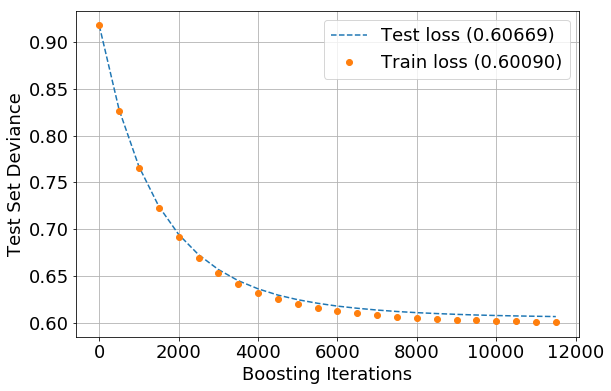

In [40]:
if plotLoss:
    plotEvery = 500
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(9,6))
    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::plotEvery], test_deviance[::plotEvery], '--', label='Test loss ({:.5f})'.format(test_deviance[-1]))
    plt.plot((np.arange(train_deviance.shape[0]) + 1)[::plotEvery], train_deviance[::plotEvery], 'o', label='Train loss ({:.5f})'.format(train_deviance[-1]))
    plt.legend(loc='best')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Test Set Deviance')
    # plt.yscale('log')
    plt.grid()
    plt.show()
    fig.savefig('./kinObsMVA/trainHistory_clfGBC_tauVall_{}{}.png'.format(version, cat.name))

In [28]:
# xq2 = np.arange(-1.9, 11.1, 0.8)
# limEstMu = [0.3,2.5, 0.05]
# limM2miss = [-2, 8.0, 0.05]

# x = np.arange(limEstMu[0], limEstMu[1]+limEstMu[2], limEstMu[2])
# x = 0.5*(x[:-1] + x[1:])
# y = np.arange(limM2miss[0], limM2miss[1]+limM2miss[2], limM2miss[2])
# y = 0.5*(y[:-1] + y[1:])
# x2 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
# # print x.shape, y.shape, x2.shape

# y, x = np.mgrid[slice(limM2miss[0], limM2miss[1]+limM2miss[2], limM2miss[2]),
#                 slice(limEstMu[0], limEstMu[1]+limEstMu[2], limEstMu[2])]
# # print x.shape
# # print y.shape

# # print x
# # print y
# # print
# # print x2[:,0].reshape(x.shape[0]-1, x.shape[1]-1)

# fig, axes = plt.subplots(4,4, figsize=(18,16))
# for i in range(xq2.shape[0] - 1):
# # i=3
#     ax = axes[i/4, i%4]

#     auxq2 = 0.5*(xq2[i] + xq2[i+1])*np.ones(x2.shape[0])
#     xIn = np.column_stack((auxq2, x2))
#     p = clfGBC.predict_proba(xIn)
#     p = p[:,1].reshape(x.shape[0]-1, x.shape[1]-1)
#     c = ax.pcolorfast(x, y, p, cmap='viridis', vmin=0, vmax=1)
#     fig.colorbar(c, ax=ax)
#     ax.set_xlabel(r'$E^{*}_{\mu}$ [GeV]')
#     ax.set_ylabel('$M^{2}_{miss}$ '+'$[GeV^2]$')
#     ax.set_title('$q^2$ = '+'{:.1f} '.format(auxq2[0]) + '$GeV^2$')

# fig.tight_layout(pad=1.5)
# fig.savefig('./kinObsMVA/scoreMap_clfGBC_tauVall_{}{}.png'.format(version, cat.name))

In [29]:
histos = {}
histoq2 = [{}, {}, {}, {}]
binsq2 = [-2, 2.5, 6, 9.4, 12]
predProba = {}

for n in sampleX.keys():
    print n
    p = clfGBC.predict_proba(sampleX[n])
    predProba[n] = p
    histos[n] = create_TH1D(p[:,1], name='h'+n, binning=[80, 0, 1.2], weights=sampleWeights[n],
                            axis_title=['GBC predicted probability', 'Expected events'])
    
    for i, (q2low, q2high) in enumerate(zip(binsq2[:-1], binsq2[1:])):
        sel = np.logical_and(sampleX[n][:,0] >= q2low, sampleX[n][:,0] < q2high)
        histoq2[i][n] = create_TH1D(p[:,1][sel], name='hq2'+n+str(i), binning=[60, 0, 1.2], 
                                   weights=sampleWeights[n][sel],
                                   axis_title=['GBC predicted probability', 'Expected events']
                                  )
histos['data'] = histos['mu'].Clone('placeholderData')
histos['data'].Reset()
for i, hdic in enumerate(histoq2):
    hdic['data'] = hdic['mu'].Clone('placeholderData_q2'+str(i))
    hdic['data'].Reset()

tau
DstmD0
BmDstmHc
DstPipPi0
DstPi0
antiB0DstmHc
mu
DstmDsp
DstPip
DstPipPim
DstmDp
BpDstmHc
DstPi0Pi0


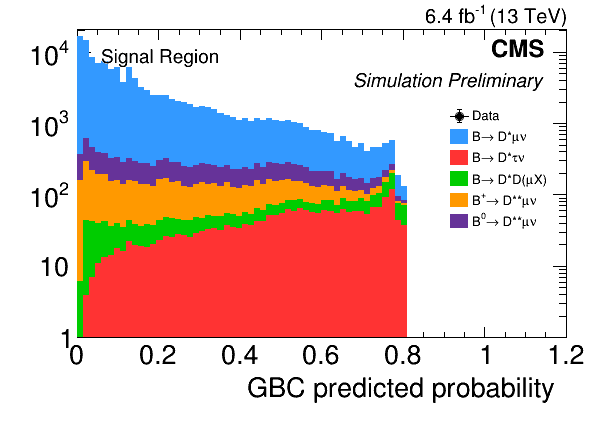

In [30]:
c = plot_SingleCategory(CMS_lumi, histos,
                        addText='Signal Region', min_y=1, tag='log', logy=True,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['tau', 'DstD', 'Dstst', 'mu']
                       )
c.Draw()
c.SaveAs('./kinObsMVA/scores_clfGBC_tauVall_{}{}.png'.format(version, cat.name))

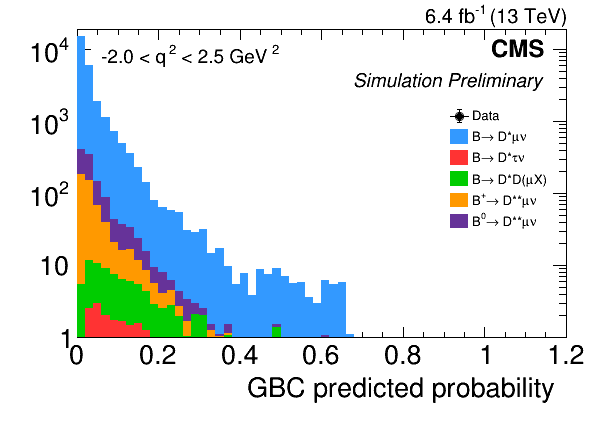

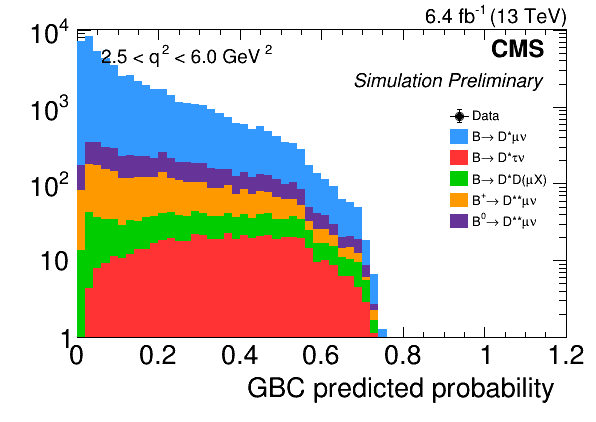

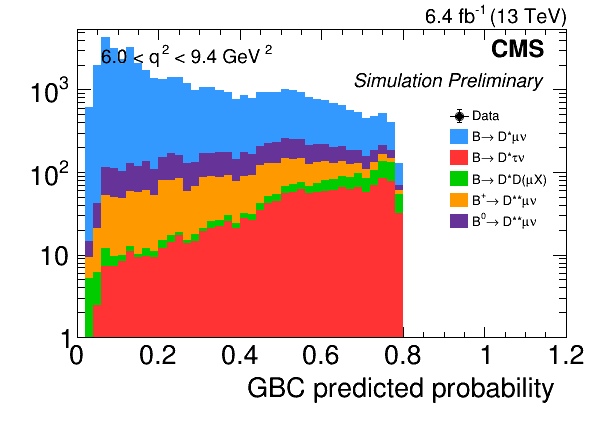

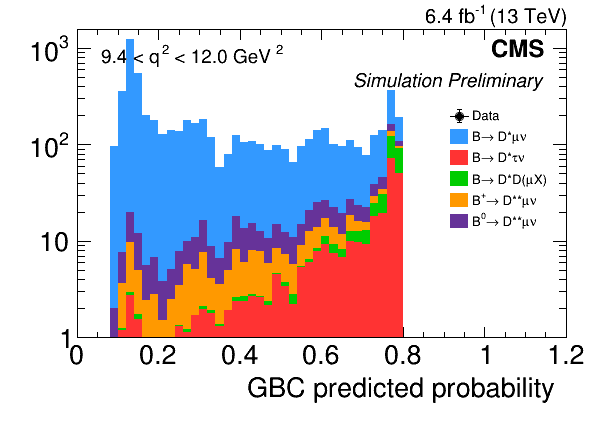

In [31]:
cvs = len(histoq2)*[None]
for i, hdic in enumerate(histoq2):
    q2Text = '{:.1f} < q^{{2}} < {:.1f} GeV^{{2}}'.format(binsq2[i], binsq2[i+1])
    cvs[i] = plot_SingleCategory(CMS_lumi, hdic,
                        addText=q2Text, min_y=1, tag='logq2'+str(i), logy=True,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['tau', 'DstD', 'Dstst', 'mu']
                       )
    cvs[i].Draw()
    cvs[i].SaveAs('./kinObsMVA/scores_clfGBC_tauVall_{}{}_q2bin{}.png'.format(version, cat.name, i))

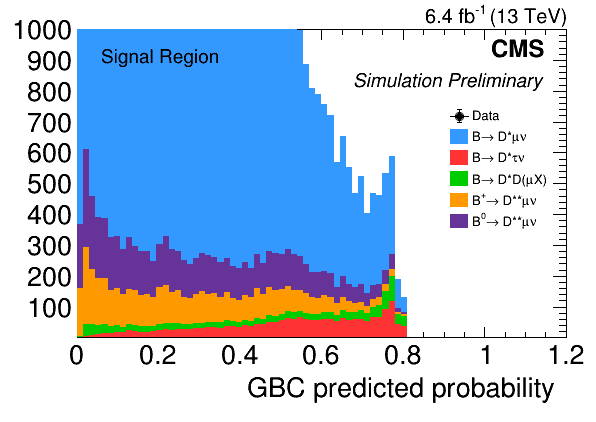

In [32]:
C = plot_SingleCategory(CMS_lumi, histos,
                        addText='Signal Region', min_y=1, tag='lin', logy=False,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                        max_y = 1000
                       )
C.Draw()

# Three samples (Tau vs Mu vs Bkg)

In [33]:
# weightsBkg = np.array([])
# xBkg = np.zeros((0,3))
# for n in sampleWeights.keys():
#     if not n in ['tau', 'mu']:
#         weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
#         xBkg = np.concatenate((xBkg, sampleX[n]))

# wTot = np.sum(weightsBkg) + np.sum(sampleWeights['tau']) + np.sum(sampleWeights['mu'])
# fBkg = np.sum(weightsBkg)/wTot
# fTau = np.sum(sampleWeights['tau'])/wTot
# fMu = np.sum(sampleWeights['mu'])/wTot
# print fTau, fMu, fBkg

In [34]:
# X = np.concatenate((xBkg, sampleX['tau'], sampleX['mu']))
# weights = np.concatenate((weightsBkg/fBkg, sampleWeights['tau']/fTau, sampleWeights['mu']/fMu))

# yBkg = 0*np.ones_like(weightsBkg)
# yMu = 1*np.ones_like(sampleWeights['mu'])
# yTau = 2*np.ones_like(sampleWeights['tau'])
# y = np.concatenate((yBkg, yTau, yMu))

In [35]:
# X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=0)

## GBC Classifier

In [36]:
# fname = './kinObsMVA/clfGBC_bkgVmuVtau_{}{}.p'.format(version, cat.name)
# if reTrain or not os.path.exists(fname):
#     clfGBC = GradientBoostingClassifier(
#         learning_rate=0.001, 
#         n_estimators=1000, 
#         min_samples_split=5, 
#         min_weight_fraction_leaf=1e-3, 
#         max_depth=3, 
#         verbose=1,
#         random_state=0
#     )

#     clfGBC.fit(X_train, y_train, sample_weight=w_train)

#     sTrain = clfGBC.score(X_train, y_train, sample_weight=w_train)
#     sTest = clfGBC.score(X_test, y_test, sample_weight=w_test)
#     print 'Accuracy: {:.5f} (train), {:.5f} (test)'.format(sTrain, sTest)
#     pickle.dump(clfGBC, open(fname, 'wb')) 
# else:
#     clfGBC = pickle.load(open(fname, 'rb'))

In [37]:
# pMu = clfGBC.predict_proba(sampleX['mu'])
# pTau = clfGBC.predict_proba(sampleX['tau'])
# pBkg = clfGBC.predict_proba(xBkg)

In [38]:
# probs = [pMu, pTau, pBkg]
# weights = [sampleWeights['mu'], sampleWeights['tau'], weightsBkg]
# tag = ['mu', 'tau', 'bkg']
# dnd = []
# for p, w, t in zip(probs, weights, tag):
#     h = create_TH2D(p[:, 1:], 
#                     binning=[50,0,1,50,0,1], 
#                     name='h2_'+t,
#                     axis_title=['GBC p(#mu)', 'GBC p(#tau)', 'Events '+t], 
#                     weights=w)
#     dnd.append(drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='c_'+t, mR=0.2))

In [39]:
# histos = {}
# for n in sampleX.keys():
#     p = clfGBC.predict_proba(sampleX[n])
#     histos[n] = create_TH1D(p[:,2], name='h'+n, binning=[100, 0, 1], weights=sampleWeights[n],
#                             axis_title=['GBC predicted Tau class probability', 'Expected events'])
# histos['data'] = histos['mu'].Clone('placeholderData')
# histos['data'].Reset()